In [1]:
import CGA_onlyfuncions as cga
import numpy as np
from obj_func import obj_func
from read_instance import read_instance
import random
import seaborn as sns
from random import randint

In [2]:
file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\a280_n279_bounded-strongly-corr_01.ttp","r")
#file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\my_test.ttp","r")
dic=read_instance(file)


In [3]:
def create_knap_pop(dic,y,x):
    pop_knap=np.zeros((y,x,dic["number of items"]))
    for i in range(pop_knap.shape[0]):
        for l in range(pop_knap.shape[1]):
            for x in range(dic["number of items"]):
                item_pick=[]
                item_pick.append(random.randint(0, 1))
                item_pick2=np.array(item_pick)
                pop_knap[i,l]=item_pick2
    return pop_knap

In [4]:
def create_tsp_pop(dic,y,x):
    pop_tsp=np.zeros((y,x,dic["number cities"]-1))
    for i in range(pop_tsp.shape[0]):
        for l in range(pop_tsp.shape[1]):
            order_cities=list(range(2,dic["number cities"]+1 ))
            random.shuffle(order_cities)
            pop_tsp[i,l,:]=order_cities
    return pop_tsp

In [5]:
def fit_loop(dic,pop_tsp,pop_knap):
    fitness=np.zeros((Y,X))
    for i in range(Y):
        for l in range(X):
            fitness[i,l]=obj_func(dic,pop_tsp[i,l,:],pop_knap[i,l,:])
    return fitness

[-170477.75040625173, -170834.25614013078, -170576.36756164234, -169960.51250654183, -169298.90392274564, -167881.58592034428, -166517.89088686332, -166653.91998679197, -166577.4626318833, -165446.27010935673, -165655.8383574171, -165670.91389034246, -165739.48650701795, -165570.45002642545, -164980.03061252282, -165398.52886759603, -164734.82964727923, -163416.43241434754, -162930.67192252807, -162010.80902016762, -161591.62289836956, -163140.0251087917, -162993.26244253208, -161776.36813839627, -161450.23557956444, -161090.31602653282, -159960.23595358845, -159531.21409340086, -159841.7366274045, -160553.63052844213, -158495.4692571356, -158495.4692571356, -158155.45923362696, -157935.47939647816, -158545.07544568146, -157283.3328054977, -157283.3328054977, -157409.5775966999, -157218.94261133476, -157529.9399087761, -157267.01314690785, -155758.32484682073, -156894.29372876082, -156123.08057731763, -156123.08057731763, -155527.67223120618, -155454.7088365017, -155232.91527580188, -1

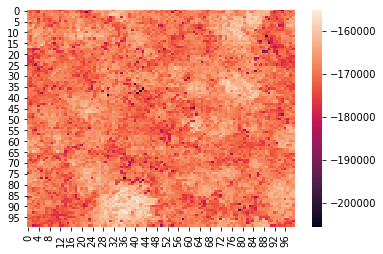

In [8]:
X=100
Y=100
pop_knap=create_knap_pop(dic,Y,X)
pop_tsp=create_tsp_pop(dic,Y,X)
iterations=50
mr=.1
maximos=[]
for p in range(iterations):
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    pop_knap=cga.crossover(fitness,pop_knap,Y,X,mr,True,False)
    pop_tsp=cga.crossover(fitness,pop_tsp,Y,X,mr,False,True)
    maximos.append(np.amax(fitness))
    
fitness=fit_loop(dic,pop_tsp,pop_knap)
maximos.append(np.amax(fitness))
print(maximos)
p1 = sns.heatmap(fitness)    
